In [1]:
########################################################

# If running with Google Colab

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
########################################################

# If running with Google Colab

!ls "/content/gdrive/My Drive/Datasets/Testing"

sample0_period1.txt  sample1_period1.txt  sample2_period1.txt
sample0_period2.txt  sample1_period2.txt  sample2_period2.txt
sample0_period3.txt  sample1_period3.txt  sample2_period3.txt


In [0]:
# import numpy as np
# import pandas as pd
# import os
# import matplotlib.pyplot as plt
# import sys
# import json
# from datetime import datetime
# from tqdm import tqdm
# %matplotlib inline

# import random
# np.random.seed(42)
# random.seed(42)

# # Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

# # training and Testing directories
# training_dir = os.path.join("Datasets", "Training")
# testing_dir = os.path.join("Datasets", "Testing")
# if not os.path.isdir(training_dir):
#     raise Exception("ERROR: training dataset not found")
# if not os.path.isdir(testing_dir):
#     raise Exception("ERROR: testing dataset not found")

In [0]:
########################################################

# If running with Google Colab

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
import json
from datetime import datetime
from tqdm import tqdm
%matplotlib inline
plt.style.use('default')


import random
np.random.seed(42)
random.seed(42)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

training_dir = Path("/content/gdrive/My Drive/Datasets/Training")
testing_dir = Path("/content/gdrive/My Drive/Datasets/Testing")

## Establish Locations

In [5]:
# iterate over all hashtag files 
for root, dirs, files in os.walk(training_dir, topdown=False):
    for file in files:
        print(os.path.join(root, file))

/content/gdrive/My Drive/Datasets/Training/tweets_#superbowl.txt
/content/gdrive/My Drive/Datasets/Training/tweets_#sb49.txt
/content/gdrive/My Drive/Datasets/Training/tweets_#patriots.txt
/content/gdrive/My Drive/Datasets/Training/tweets_#gohawks.txt
/content/gdrive/My Drive/Datasets/Training/tweets_#gopatriots.txt
/content/gdrive/My Drive/Datasets/Training/tweets_#nfl.txt


In [0]:
# Look at the gopatriots dataset for testing
# change to only_superbowl = ['superbowl'] for actual running

only_superbowl = ['superbowl']
only_gopatriots = ['gopatriots'] 

In [7]:
# Testing with Full Size
locations = []

# iterate over all hashtag files 
for root, dirs, files in os.walk(training_dir, topdown=False):
    for file in files:
        filename = os.path.splitext(file)[0].replace('tweets_#', '')
          
        # CHANGE TO only_superbowl for final submission
        # Only Look at the gopatriots Data file for testing
        if not filename in only_superbowl:
#         if not filename in only_gopatriots:
            continue
        
        print('Parsing {}...'.format(filename))
        
        # only extracting specific features from the tweet json objects
        citation_dates = []
        
        # open the file and read all lines:
        with open(os.path.join(root, file), "r", encoding="utf-8") as hashtag:
            # read line-by-line
            for line in hashtag:
                json_obj = json.loads(line)
                
                # get citation date
                citation_date = json_obj['citation_date']
                citation_dates.append(citation_date)
                
                # get locations 
                location = json_obj['tweet']['user']['location']
                locations.append(location)
        
        # processing citation feature
        print('\t'+'-'*10)
        citation_dates = np.array(citation_dates)
        print('\tnumber of tweets in period: {}'.format(len(citation_dates)))
        min_date = np.min(citation_dates)
        max_date = np.max(citation_dates)

        # processing all locations
        print('\t'+'-'*10)
        print('\tnumber of locations in {} dataset: {}'.format(filename, len(locations)))
        
        print('\t'+'-'*10)
        print('')

Parsing superbowl...
	----------
	number of tweets in period: 1213813
	----------
	number of locations in superbowl dataset: 1213813
	----------



In [8]:
unique_locations = []

for location in locations:
    if location in unique_locations: # Avoid duplicates
        continue

    unique_locations.append(location)
    
print('number of unique locations is: {}'.format(len(unique_locations)))

number of unique locations is: 179770


## Determine if in MA or WA

In [9]:
# Define Locations

MA_WA = [' MA',' WA', 'Massachusetts', 'Washington', 'Boston', 'Seattle'] # Look for all possible MA and WA matches
# NOTE: added 'space' before MA and WA to avoid problems such as IOWA; Could do this differently

all_MA_WA = [location for location in unique_locations if any(place in location for place in MA_WA)] # Create list of all places in MA and WA

DC = ['DC', 'D.C.', 'D.C']

all_MA_WA_no_DC = [location for location in all_MA_WA if not any(place in location for place in DC)] # remove DC and D.C.

MA = [' MA', 'Massachusetts', 'Boston'] # Get just locations in Massachusetts
WA = [' WA', 'Washington', 'Seattle'] # Get just locations in Washington

only_MA = [location for location in all_MA_WA_no_DC if any(place in location for place in MA)] # Get just locations in Massachusetts
only_WA = [location for location in all_MA_WA_no_DC if any(place in location for place in WA)] # Get just locations in Washington

print('number of unique locations in MA or WA : {}'.format(len(all_MA_WA)))
print('-'*10)
print('number of unique locations in MA or WA after removing DC: {}'.format(len(all_MA_WA_no_DC)))
print('-'*10)
print('number of locations in MA: {}'.format(len(only_MA)))
print('-'*10)
print('number of locations in WA: {}'.format(len(only_WA)))

# print('-'*10)
# print('Locations in MA and WA: ','\n', *all_MA_WA_no_DC, sep = "\n")
# print('-'*10)
# print('Locations in MA: ','\n', *only_MA, sep = "\n")
# print('-'*10)
# print('Locations in WA: ','\n', *only_WA, sep = "\n")

number of unique locations in MA or WA : 5119
----------
number of unique locations in MA or WA after removing DC: 4650
----------
number of locations in MA: 2484
----------
number of locations in WA: 2182


## Extract all tweets from WA or MA

In [10]:
# Extract all tweets from WA or MA

# Testing with Fullsize File

# Store textual data and location labels 0 if MA 1 if WA 
tweet_textual_data = [] 
tweet_location_labels = []

# Initialize counting variables to keep track of number of tweets from MA and WA
num_tweets_MA = 0
num_tweets_WA = 0

for root, dirs, files in os.walk(training_dir, topdown=False):
    for file in files:
        filename = os.path.splitext(file)[0].replace('tweets_#', '')
          
        # CHANGE TO only_superbowl for final submission
        # Only Look at the gopatriots Data file for testing
        if not filename in only_superbowl:
#         if not filename in only_gopatriots:
            continue
        
        print('Parsing {}...'.format(filename))
        
        # only extracting specific features from the tweet json objects
        
        # open the file and read all lines:
        with open(os.path.join(root, file), "r", encoding="utf-8") as hashtag:
            # read line-by-line
            for line in hashtag:
                json_obj = json.loads(line)
                
                # get tweets that are only in MA and WA (not DC)
                location = json_obj['tweet']['user']['location']
                
                if not any(MAWA in location for MAWA in all_MA_WA_no_DC):
                    continue
                
                if any (loc in location for loc in only_MA):
                    # get textual data
                    text = json_obj['tweet']['text'] 
                    tweet_textual_data.append(text)
                    
                    # add location is in MA (0)
                    tweet_location_labels.append(0)
                    
                    num_tweets_MA += 1
                    
                if any (loc in location for loc in only_WA):
                    if any (loc in location for loc in DC): # Check if contains DC
                        continue
                        
                    # get textual data
                    text = json_obj['tweet']['text'] 
                    tweet_textual_data.append(text)
                
                    # add location is in WA (1)
                    tweet_location_labels.append(1)
                                         
                    num_tweets_WA += 1    
                    
        # process textual data
        print('\t'+'-'*10)
        print('\tNumber of texts in {} dataset: {}'.format(filename, len(tweet_textual_data)))
        
        # Process MA and WA locations
        print('\t'+'-'*10)
        print('\tNumber of tweets from MA and WA is: {}'.format(len(tweet_location_labels)))
        
        print('\t'+'-'*10)
        print('\tNumber of tweets from MA is: ', num_tweets_MA)
        
        print('\t'+'-'*10)
        print('\tNumber of tweets from WA is: ', num_tweets_WA)
        
#         print('\t'+'-'*10)
#         print('\tTextual data looks like: ', *tweet_textual_data, sep = "\n")
        
#         print('\t'+'-'*10)
#         print('\tLabels look like: ', tweet_location_labels)

Parsing superbowl...
	----------
	Number of texts in superbowl dataset: 37058
	----------
	Number of tweets from MA and WA is: 37058
	----------
	Number of tweets from MA is:  19815
	----------
	Number of tweets from WA is:  17243


In [0]:
tweet_location_labels = np.asarray(tweet_location_labels)

class_names = ['Massachusetts', "Washington"]

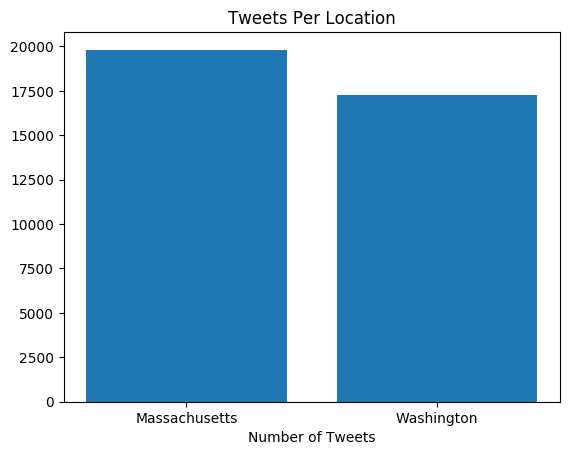

In [12]:
# Plot distribution of tweets per locations

plt.bar([0,1],[num_tweets_MA, num_tweets_WA])
plt.xticks([0,1], class_names)
plt.xlabel('Number of Tweets')
plt.title("Tweets Per Location")
plt.show()

## Define training and testing datasets

In [0]:
# Define training and testing datasets

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

X = np.asarray(tweet_textual_data)
y = tweet_location_labels

kf = KFold(n_splits=5, shuffle = True)

for trainset, testset in kf.split(X):
    X_train, X_test = X[trainset], X[testset]
    y_train, y_test = y[trainset], y[testset]

## Lemmatization & Count Vectorization

In [14]:
# Lemmatization functions used by CountVectorizer

# The lemmatizer is actually pretty complicated, it needs Parts of Speech (POS) tags
import nltk
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN': 'n', 'JJ': 'a',
                  'VB': 'v', 'RB': 'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

wnl = nltk.wordnet.WordNetLemmatizer()
def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

def isfloat(string):
    try:
        float(string)
        return True
    except:
        return False

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if not isfloat(word))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
# Push lemmatized documents through CountVectorizer

count_vect = CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')

# do for training
X_lemmatized_train_counts = count_vect.fit_transform(X_train)

# do for testing
X_lemmatized_test_counts = count_vect.transform(X_test)

## Feature Extraction

In [16]:
# Report shapes of TF-IDF matrices

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# do for training
X_lemmatized_train_tfidf = tfidf_transformer.fit_transform(X_lemmatized_train_counts)
print(X_lemmatized_train_tfidf.shape)

# do for testing
X_lemmatized_test_tfidf = tfidf_transformer.transform(X_lemmatized_test_counts)
print(X_lemmatized_test_tfidf.shape)

(29647, 6169)
(7411, 6169)


## Dimensionality Reduction

### NMF

In [17]:
# Perform NMF

from sklearn.decomposition import NMF

model = NMF(n_components=50, init='random', random_state=42)
W_nmf_train_reduced = model.fit_transform(X_lemmatized_train_tfidf)
H_nmf_train_reduced = model.components_

print(W_nmf_train_reduced.shape)
print(H_nmf_train_reduced.shape)

W_nmf_test_reduced = model.transform(X_lemmatized_test_tfidf)
H_nmf_test_reduced = model.components_

(29647, 50)
(50, 6169)


### LSI

In [18]:
# Perform LSI using the truncated SVD

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
X_lsi_train_reduced = svd.fit_transform(X_lemmatized_train_tfidf)
Y_lsi_train_reduced = svd.components_
print(X_lsi_train_reduced.shape)
print(svd.components_.shape)

X_lsi_test_reduced = svd.transform(X_lemmatized_test_tfidf)
Y_lsi_test_reduced = svd.components_
print(X_lsi_train_reduced.shape)
print(svd.components_.shape)

(29647, 50)
(50, 6169)
(29647, 50)
(50, 6169)


In [19]:
# Compare LSI and NMF (Training)

nmf_val = np.linalg.norm(X_lemmatized_train_tfidf - np.matmul(W_nmf_train_reduced, H_nmf_train_reduced), 'fro')**2
lsi_val = np.linalg.norm(X_lemmatized_train_tfidf - np.matmul(X_lsi_train_reduced, Y_lsi_train_reduced), 'fro')**2

print('Training NMF: ', nmf_val)
print('Training LSI: ', lsi_val)

Training NMF:  22825.738712223032
Training LSI:  22754.8605264166


In [20]:
# Compare LSI and NMF (Testing)

nmf_val = np.linalg.norm(X_lemmatized_test_tfidf - np.matmul(W_nmf_test_reduced, H_nmf_test_reduced), 'fro')**2
lsi_val = np.linalg.norm(X_lemmatized_test_tfidf - np.matmul(X_lsi_test_reduced, Y_lsi_test_reduced), 'fro')**2

print('Testing NMF: ', nmf_val)
print('Testing LSI: ', lsi_val)

Testing NMF:  5651.060898473434
Testing LSI:  5636.109302657658


## Define Confusion Matrix Plot

In [0]:
# Taken from scikit-learn website: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Classifier Training

### 1. SVM with Hard and Soft Margin, (LSI)

In [0]:
# Training 2 linear SVMs using LSI

from sklearn.svm import LinearSVC

# hard margin
gamma_1 = 1000
clf_svc_1 = LinearSVC(C=gamma_1,max_iter=100000).fit(X_lsi_train_reduced, y_train)
predicted_svc_1 = clf_svc_1.predict(X_lsi_test_reduced)

# using max_iter=100000 because otherwise the hard margin classifier does not converge

#soft margin
gamma_2 = 0.0001
clf_svc_2 = LinearSVC(C=gamma_2,max_iter=100000).fit(X_lsi_train_reduced, y_train)
predicted_svc_2 = clf_svc_2.predict(X_lsi_test_reduced)

#### 1.1 SVM Hard Margin Metrics

Confusion matrix, without normalization
[[3741  204]
 [1372 2094]]


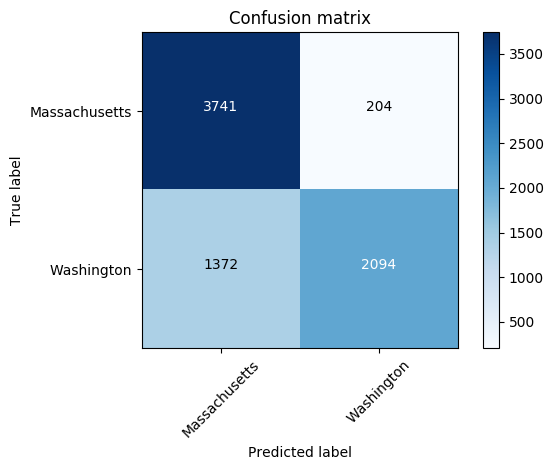

Normalized confusion matrix
[[0.94828897 0.05171103]
 [0.39584535 0.60415465]]


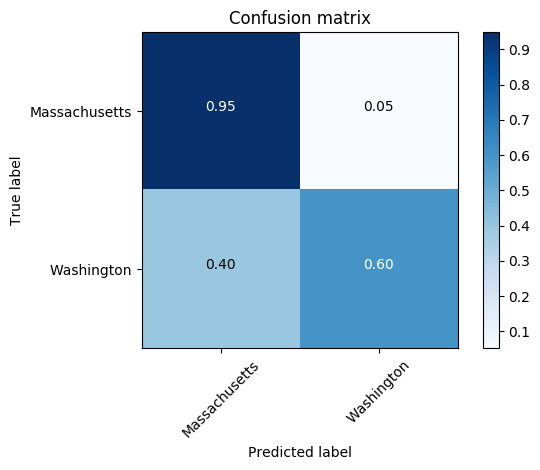

Accuracy for linear SVM hard margin:  0.7873431385777898
Precision score for linear SVM hard margin:  0.9112271540469974
Recall score for linear SVM hard margin:  0.6041546451240624
F-1 score for linear SVM hard margin: 0.7265787647467038


In [25]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores for the hard margin

# Confusion matrix
from sklearn.metrics import confusion_matrix

# print('Confusion matrix for linear SVM hard margin: \n', confusion_matrix(twenty_test_binary_labels, predicted_svc_1))

plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predicted_svc_1), classes=class_names)
plt.show()

plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predicted_svc_1), classes=class_names, normalize=True)
plt.show()

# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy for linear SVM hard margin: ', accuracy_score(y_test, predicted_svc_1))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score for linear SVM hard margin: ', precision_score(y_test, predicted_svc_1))
print('Recall score for linear SVM hard margin: ', recall_score(y_test, predicted_svc_1))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score for linear SVM hard margin:', f1_score(y_test, predicted_svc_1))

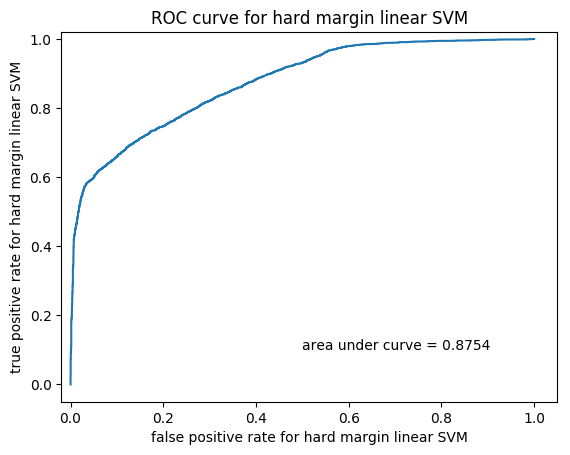

In [26]:
# ROC curve for hard margin SVM

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

score_svc_1 = clf_svc_1.decision_function(X_lsi_test_reduced)
fpr_svc_1, tpr_svc_1, thresholds_svc_1 = roc_curve(y_test, score_svc_1)

plt.figure()
plt.plot(fpr_svc_1, tpr_svc_1)
plt.title('ROC curve for hard margin linear SVM')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(y_test, score_svc_1))
plt.xlabel('false positive rate for hard margin linear SVM')
plt.ylabel('true positive rate for hard margin linear SVM')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.show()

#### 1.2 SVM Soft Margin Metrics

Confusion matrix, without normalization
[[3940    5]
 [3063  403]]


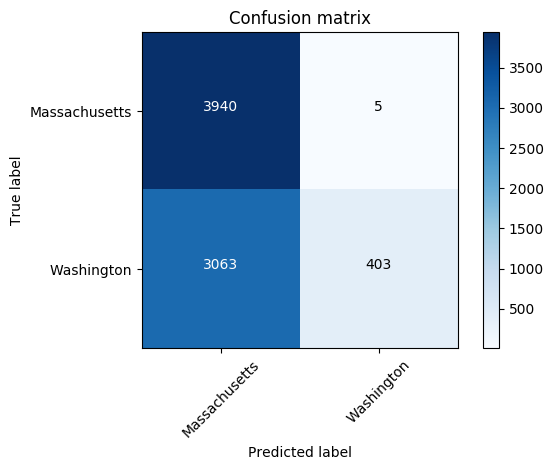

Normalized confusion matrix
[[0.99873257 0.00126743]
 [0.88372764 0.11627236]]


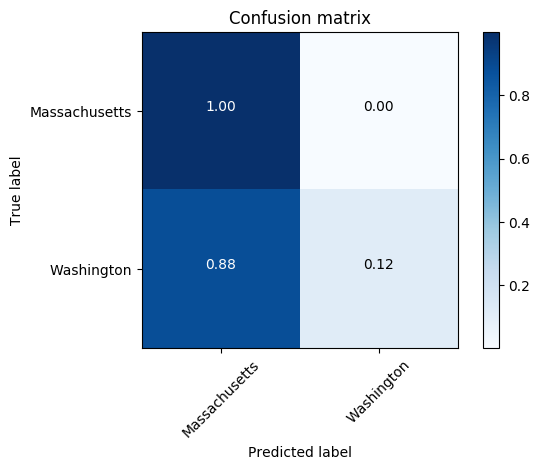

Accuracy for linear SVM soft margin:  0.586020779921738
Precision score for linear SVM soft margin:  0.9877450980392157
Recall score for linear SVM soft margin:  0.11627236006924409
F-1 score for linear SVM soft margin: 0.2080536912751678


In [27]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores for the soft margin

# Confusion matrix
from sklearn.metrics import confusion_matrix

# print('Confusion matrix for linear SVM soft margin: \n', confusion_matrix(twenty_test_binary_labels, predicted_svc_2))

plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predicted_svc_2), classes=class_names)
plt.show()

plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predicted_svc_2), classes=class_names, normalize=True)
plt.show()

# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy for linear SVM soft margin: ', accuracy_score(y_test, predicted_svc_2))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score for linear SVM soft margin: ', precision_score(y_test, predicted_svc_2))
print('Recall score for linear SVM soft margin: ', recall_score(y_test, predicted_svc_2))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score for linear SVM soft margin:', f1_score(y_test, predicted_svc_2))

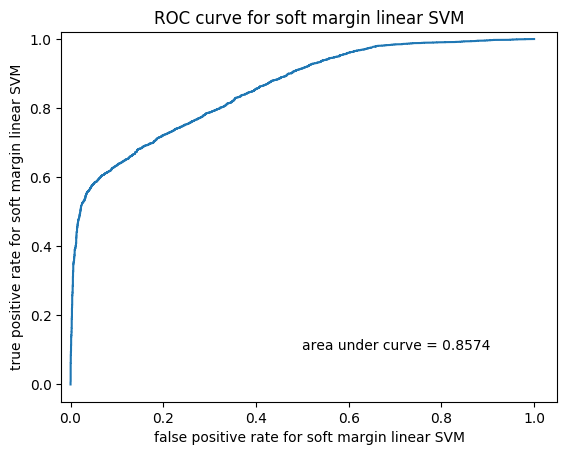

In [28]:
# ROC curve for soft margin SVM

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

score_svc_2 = clf_svc_2.decision_function(X_lsi_test_reduced)
fpr_svc_2, tpr_svc_2, thresholds_svc_2 = roc_curve(y_test, score_svc_2)

plt.figure()
plt.plot(fpr_svc_2, tpr_svc_2)
plt.title('ROC curve for soft margin linear SVM')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(y_test, score_svc_2))
plt.xlabel('false positive rate for soft margin linear SVM')
plt.ylabel('true positive rate for soft margin linear SVM')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.show()

###  2. Logistic Regression without Regularization

In [0]:
# Train an unregularized logistic regression classifier.

from sklearn.linear_model import LogisticRegression

# To be unregularized, we make the inverse of the regularization strength C 
# to be large to approximate an unregularized classifier.
clf = LogisticRegression(random_state=42, C=500, max_iter=100, solver='lbfgs').fit(X_lsi_train_reduced, y_train)

# score = clf.decision_function(X_lsi_test_reduced)
predicted = clf.predict(X_lsi_test_reduced)

#### 2.1 Logistic Regression without Regularization Metrics

Confusion matrix, without normalization
[[3723  222]
 [1335 2131]]


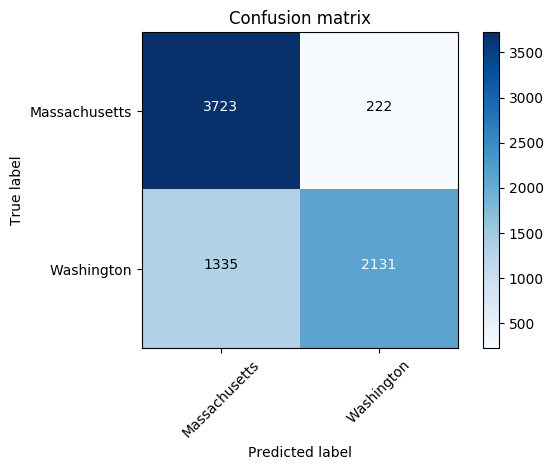

Normalized confusion matrix
[[0.94372624 0.05627376]
 [0.38517023 0.61482977]]


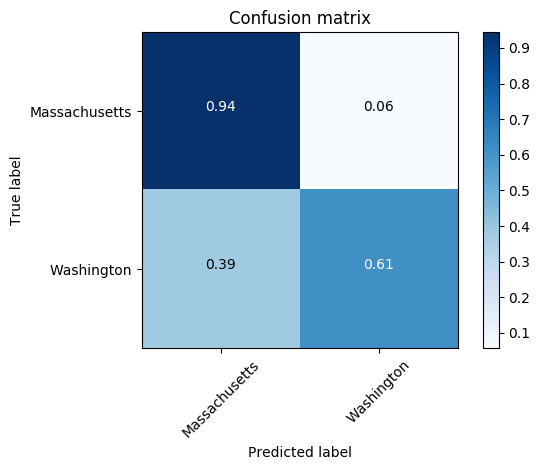

Accuracy:  0.7899068951558494
Precision score:  0.9056523586910328
Recall score:  0.6148297749567224
F-1 score: 0.7324282522770236


In [30]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores

# Confusion matrix
from sklearn.metrics import confusion_matrix

# print('Confusion matrix: \n', confusion_matrix(twenty_test_binary_labels, predicted))
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predicted), classes=class_names)
plt.show()
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predicted), classes=class_names, normalize=True)
plt.show()

# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(y_test, predicted))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score: ', precision_score(y_test, predicted))
print('Recall score: ', recall_score(y_test, predicted))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score:', f1_score(y_test, predicted))

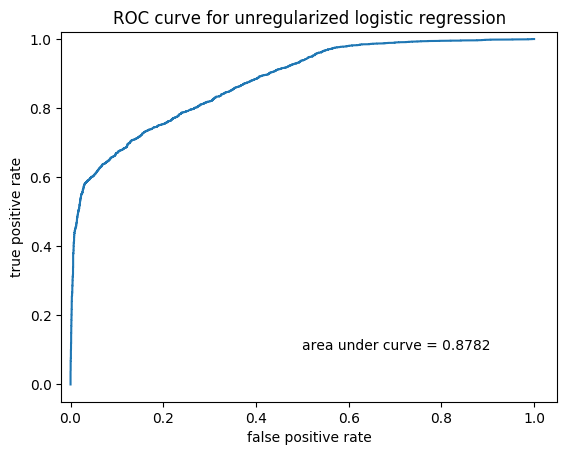

In [31]:
# ROC curve

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

score = clf.decision_function(X_lsi_test_reduced)
fpr, tpr, thresholds = roc_curve(y_test, score)

plt.figure()
plt.plot(fpr, tpr)
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(y_test, score))
plt.title('ROC curve for unregularized logistic regression')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.show()

### 3. Logistic Regression With L1 & L2 Regularization

Optimal regularization strength for L1 Regulation:  [10.]
Accuracy with L1 Regulation for L1 Regulation:  0.7878828768047497
Average precision-recall score for L1 Regulation: 0.7387990017294028
Precision score for L1 Regulation:  0.9216384683882458
Recall score for L1 Regulation:  0.5972302365839585
F-1 score for L1 Regulation: 0.7247899159663866


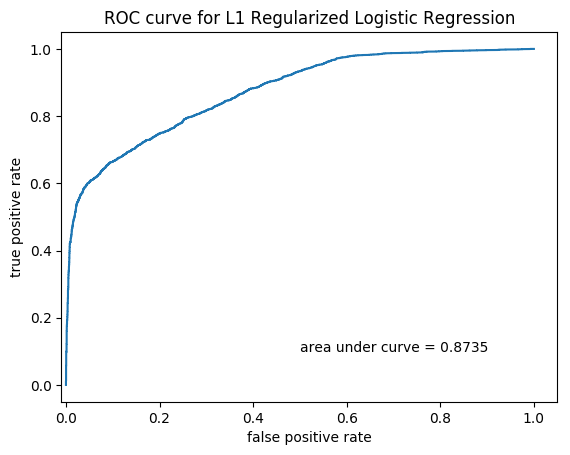


Optimal regularization strength for L2 regulation:  [0.001]
Accuracy with L2 Regulation:  0.7897719605991095
Average precision-recall score for L2 Regulation: 0.7368086559848378
Precision score for L2 Regulation:  0.9056122448979592
Recall score for L2 Regulation:  0.6145412579342181
F-1 score for L2 Regulation: 0.7322103815744242


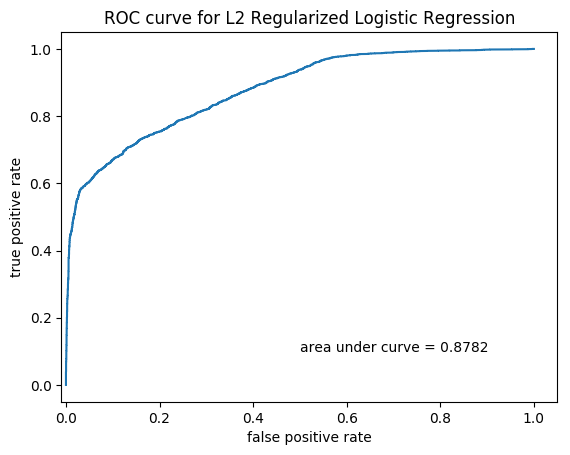

In [32]:
from sklearn.linear_model import LogisticRegressionCV

# Define training and testing data sets
X_train = X_lsi_train_reduced
X_test = X_lsi_test_reduced

# Define regularization strength values here
REG_STRENGTH_OPTIONS = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Determine regulation strength for L1 regulation
clf_L1 = LogisticRegressionCV(random_state=42, Cs=REG_STRENGTH_OPTIONS, cv=5, penalty='l1', scoring='accuracy', solver = 'liblinear').fit(X_train, y_train)
l1_reg_strength = 1/clf_L1.C_ # Regulization strength is inverse of optimal Cs
predicted_L1 = clf_L1.predict(X_test)

# Display L1 Stats
print('Optimal regularization strength for L1 Regulation: ', l1_reg_strength)
print('Accuracy with L1 Regulation for L1 Regulation: ', clf_L1.score(X_test, y_test))
print('Average precision-recall score for L1 Regulation:', average_precision_score(y_test, predicted_L1))
print('Precision score for L1 Regulation: ', precision_score(y_test, predicted_L1))
print('Recall score for L1 Regulation: ', recall_score(y_test, predicted_L1))
print('F-1 score for L1 Regulation:', f1_score(y_test, predicted_L1))

# L1 ROC Curve
score_L1 = clf_L1.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, score_L1)

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for L1 Regularized Logistic Regression')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(y_test, score_L1))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()

# Determine regulation strength for L2 regulation
clf_L2 = LogisticRegressionCV(random_state=42, Cs=REG_STRENGTH_OPTIONS, cv=5, penalty='l2', scoring='accuracy', solver = 'liblinear').fit(X_train, y_train)
L2_reg_strength = 1/clf_L2.C_ # Regulization strength is inverse of optimal Cs
predicted_L2 = clf_L2.predict(X_test)

# Display L2 Stats
print('\nOptimal regularization strength for L2 regulation: ', L2_reg_strength)
print('Accuracy with L2 Regulation: ', clf_L2.score(X_test, y_test))
print('Average precision-recall score for L2 Regulation:', average_precision_score(y_test, predicted_L2))
print('Precision score for L2 Regulation: ', precision_score(y_test, predicted_L2))
print('Recall score for L2 Regulation: ', recall_score(y_test, predicted_L2))
print('F-1 score for L2 Regulation:', f1_score(y_test, predicted_L2))

# L2 ROC Curve
score_L2 = clf_L2.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, score_L2)

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for L2 Regularized Logistic Regression')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(y_test, score_L2))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()

### 4. Naive Bayes Gaussian Classifier

In [0]:
from sklearn.naive_bayes import GaussianNB

Confusion matrix, without normalization
[[3293  652]
 [1391 2075]]


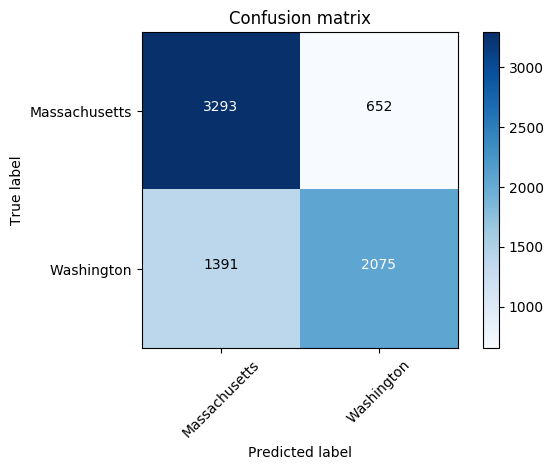

Normalized confusion matrix
[[0.8347275  0.1652725 ]
 [0.40132718 0.59867282]]


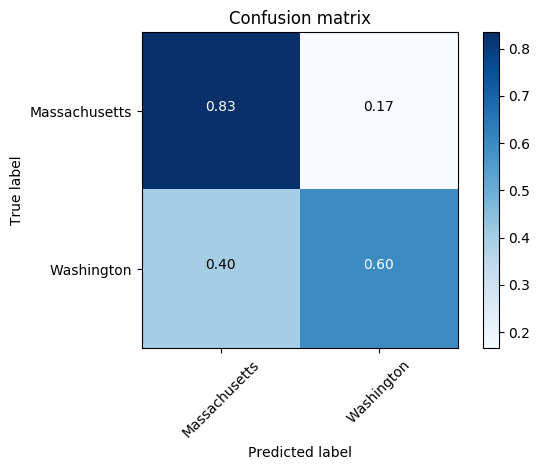

Accuracy for Gaussian NB from LSI:  0.7243287005802186
Average precision-recall score for Gaussian NB from LSI: 0.6432297605119277
Precision score for Gaussian NB from LSI:  0.7609094242757609
Recall score for Gaussian NB from LSI:  0.5986728216964801
F-1 score for Gaussian NB from LSI: 0.6701114161149686


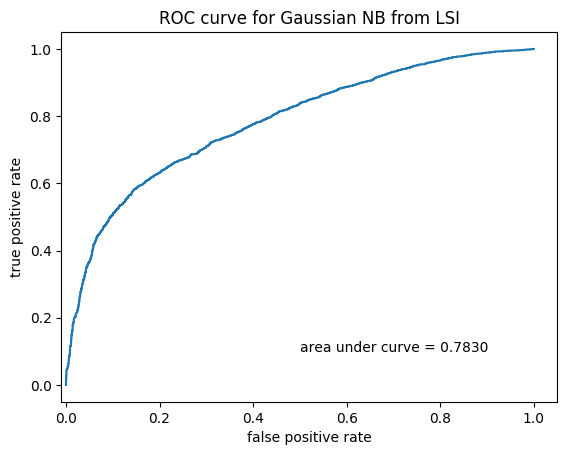

In [34]:
# Generate stats for GaussianNB using LSI for reduction

# Define training and testing data sets
X_train = X_lsi_train_reduced
X_test = X_lsi_test_reduced

clf = GaussianNB().fit(X_train, y_train)

predicted = clf.predict(X_test)

# Confusion Matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predicted), classes=class_names)
plt.show()
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predicted), classes=class_names, normalize=True)
plt.show()

# Display GNB Stats
print('Accuracy for Gaussian NB from LSI: ', clf.score(X_test, y_test))
print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for Gaussian NB from LSI: ', precision_score(y_test, predicted))
print('Recall score for Gaussian NB from LSI: ', recall_score(y_test, predicted))
print('F-1 score for Gaussian NB from LSI:', f1_score(y_test, predicted))

# GNB ROC Curve
prob_score = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, prob_score[:, 1])

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for Gaussian NB from LSI')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(y_test, prob_score[:, 1]))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()